In [1]:
# Импортирование необходимых функций и классов 
import numpy as np

from sklearn.datasets import load_breast_cancer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.utils import plot_model
from PIL import Image

In [2]:
# Загрузка данных
dataset = load_breast_cancer()
X = np.array(dataset.data)
y = np.array(dataset.target).astype('object')
X.shape, y.shape

((569, 30), (569,))

In [3]:
# Разделение данных на тренировочные/тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
# Класс кастомного классификатора
class ModelBuilder(object):
    # Конструктор класса
    def __init__(self):
        pass
    
    # Метод, используемый GridSearchCV 
    # для установки параметров
    def set_params(self, 
                   layers=[],
                   optimizer='rmsprop',
                   loss='binary_crossentropy',
                   metric=['accuracy'],
                   epochs=200,
                   batch_size=5):
        
        # Установка параметров в качестве полей класса
        self.__layers = layers
        self.__optimizer = optimizer
        self.__loss = loss
        self.__metric = metric
        self.__epochs = epochs
        self.__batch_size = batch_size

        
        # Преобразования модели в классификатор sklearn
        self.model = KerasClassifier(build_fn=self.__build, 
                                     epochs=epochs,
                                     batch_size=batch_size)
        
    # Функция для постройки модели    
    def __build(self):
        
        model = Sequential(self.__layers)
            
        model.compile(optimizer=self.__optimizer, 
                      loss=self.__loss, 
                      metrics=self.__metric)
        
        return model
    
        
    # Адаптирование модели    
    def fit(self, X, y):
        
        return self.model.fit(x=X, y=y)
    
    
    # Предсказание модели
    def predict(self, X):
        
        return self.model.predict(X)
    
    
    # Вычисление точности предсказания
    def score(self, X, y):
        
        return self.model.score(X, y)

In [5]:
# Различные наборы слоёв
params = {
    'clf__layers': [[Dense(256, activation='relu', input_shape=(30, )), Dense(256, activation='relu'), Dropout(0.4), Dense(1, activation='sigmoid')],
                   [Dense(64, activation='relu', input_shape=(30, )), Dropout(0.4), Dense(64, activation='relu'), Dense(1, activation='sigmoid')],
                   [Dense(16, activation='relu', input_shape=(30, )), Dropout(0.4), Dense(16, activation='relu'), Dense(16, activation='relu'),
                    Dropout(0.4), Dense(1, activation='sigmoid')]
                   ],
    'clf__optimizer': ['rmsprop'],
    'clf__loss': ['binary_crossentropy'],
    'clf__metric': [['accuracy']],
    'clf__epochs': [25, 50]
    }                                                                                  

In [6]:
# Инициализация трансформера
scaler = StandardScaler()

# Инициализация классификатора
clf = ModelBuilder()

# Создание конвеера
pipeline = Pipeline([('scaler', scaler), ('clf', clf)])

In [7]:
# Построение класса, выполняющего сеточный поиск
grid_search = GridSearchCV(pipeline, params)

In [8]:
# Алгоритм обучает множество моделей на тренировочных данных
grid_search.fit(X_train, y_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        <__main__.ModelBuilder object at 0x000000000E9BD9E8>)],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'clf__epochs': [25, 50],
                         'clf__layers': [[<tensorflow.python.keras.layers.core.Dense ob...
                         'clf__loss': ['binary_crossentropy'],
                         'clf__metric': [['accuracy']],
                         'clf__optimizer': ['rmsprop']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scor

In [9]:
# Лучшие "гиперпараметры", найденны поиском
params = grid_search.best_params_

layers = params['clf__layers']
metric = params['clf__metric']
optimizer = params['clf__optimizer']
epochs = params['clf__epochs']
loss = params['clf__loss']

In [10]:
# Построение модели, основываясь на лучшие "гиперпараметры"
model = Sequential(layers)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metric)

# Визуализация архитектуры
plot_model(model, to_file='model.png')

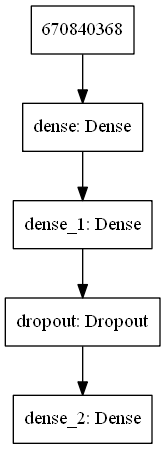

In [11]:
# Вывод изображения
img = Image.open("model.png")
img

In [12]:
model = grid_search.best_estimator_

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print('Score on train data is {0}'.format(train_score))
print('Score on test data is {0}'.format(test_score))

114/114 [==============================] - 0s 307us/sample - loss: 0.1686 - acc: 0.9825
Score on train data is 0.995604395866394
Score on test data is 0.9824561476707458
